<a href="https://colab.research.google.com/github/JMFiore/Data-shcience-Projects/blob/main/recomendation_system_Telecom_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📊🎥 Recomendation System 🎥📊

In [ ]:
!pip install lightfm

     |████████████████████████████████| 310 kB 4.9 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705358 sha256=791838fac11658f09144eb2a5de3467808371838f5383b1ee4a60e92c47032d9
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tqdm as tqdm
from lightfm import LightFM
from scipy.sparse import csr_matrix
from datetime import datetime
import missingno as msno

## Cargado de datos

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
file1_path='/content/drive/MyDrive/DataScience/Sprint N 3/metadata.csv'
file2_path='/content/drive/MyDrive/DataScience/Sprint N 3/train (2).csv'

In [ ]:
meta=pd.read_csv(file1_path,sep=";")
train=pd.read_csv(file2_path)

In [ ]:
meta.head()

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,description,reduced_desc,cast_first_name,credits_first_name,run_time_min,audience,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",Esteban recibe una noticia inesperada: va a se...,Esteban recibe una noticia inesperada: va a se...,"Rodrigo De la Serna, Paola Krum, Fernán Mirás,...",Daniel Barone,48.0,General,N,N,N,N,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",Víctor trabaja como carretillero. Un día recib...,"Trabajando como carretillero, Víctor recibe un...","Celso Franco, Víctor Sosa, Lali Gonzalez",Juan Carlos Maneglia,105.0,General,N,N,N,N,N,N,N,Y,N,N,2017-12-19T20:58:15.0Z,2019-09-17T19:02:03.0Z,2017-12-15T00:00:00.0Z,2022-12-14T23:59:59.0Z
2,21939,2.0,La Maldición de las Hormigas Gigantes,La_Maldicion_de_las,NaN,Película,2016.0,FI,Terror/Comedia,"Criaturas,Plagas,Adolescentes,Fantasía,Video J...",Un grupo de motociclistas busca diversión el d...,Un grupo de motociclistas descubre un laborato...,"Mark Arnold, Harry Lister Smith, Vanessa Grass...",Marko Mäkilaakso,82.0,Juvenil,Y,N,N,N,N,N,N,N,N,N,2018-02-16T13:51:07.0Z,2020-04-28T14:16:38.0Z,2018-01-25T00:00:00.0Z,2020-12-01T23:59:59.0Z
3,9005,3.0,Una Mujer Fantástica,Una_Mujer_Fantastic,NaN,Película,2017.0,CL,Drama,"LGBT,Mujeres,Latinoamérica",Marina y Orlando están enamorados y planean un...,Marina y Orlando están enamorados. Pero cuando...,"Daniela Vega, Francisco Reyes, Luis Gnecco, Am...",Sebastián Lelio,99.0,General,N,N,N,N,N,N,N,N,Y,N,2018-05-26T11:58:44.0Z,2019-11-15T03:00:23.0Z,2018-05-27T00:00:00.0Z,2021-04-30T23:59:59.0Z
4,7391,4.0,Star Trek,Star_Trek,NaN,Película,2009.0,US,Ciencia Ficción/Aventura,"Fantasía,Galaxia,Futurismo,Aliens,Criaturas",El descarado James T. Kirk trata de estar a la...,James T. Kirk trata de estar a la altura del l...,"Chris Pine, Zachary Quinto, Leonard Nimoy, Eri...",J.J. Abrams,126.0,General,N,N,N,N,N,N,N,Y,N,N,2019-05-03T20:07:24.0Z,2020-04-09T04:37:29.0Z,2019-05-02T00:00:00.0Z,2020-12-31T23:59:59.0Z


In [ ]:
meta.shape

(33144, 30)

In [ ]:
meta.describe()

,asset_id,content_id,released_year,run_time_min
count,33144.000000,33123.000000,33144.000000,33144.000000
mean,16571.500000,1371.500891,2016.003922,48.060916
std,9567.992997,1153.024487,6.026482,35.214128
min,0.000000,0.000000,1942.000000,0.000000
25%,8285.750000,387.000000,2015.000000,22.000000
50%,16571.500000,1019.000000,2018.000000,43.000000
75%,24857.250000,2160.000000,2019.000000,67.000000
max,33143.000000,4371.000000,2021.000000,308.000000


In [ ]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asset_id            33144 non-null  int64  
 1   content_id          33123 non-null  float64
 2   title               33144 non-null  object 
 3   reduced_title       33144 non-null  object 
 4   episode_title       28997 non-null  object 
 5   show_type           33140 non-null  object 
 6   released_year       33144 non-null  float64
 7   country_of_origin   33140 non-null  object 
 8   category            33144 non-null  object 
 9   keywords            33142 non-null  object 
 10  description         33142 non-null  object 
 11  reduced_desc        33144 non-null  object 
 12  cast_first_name     24412 non-null  object 
 13  credits_first_name  20590 non-null  object 
 14  run_time_min        33144 non-null  float64
 15  audience            33143 non-null  object 
 16  made

In [ ]:
train.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0


In [ ]:
train.shape

(3657801, 7)

In [ ]:
train.describe()

,customer_id,account_id,asset_id,resume
count,3.657801e+06,3.657801e+06,3.657779e+06,3.657801e+06
mean,5.697459e+04,5.902651e+04,1.667222e+04,4.005672e-01
std,3.090677e+04,3.237536e+04,9.666494e+03,4.900134e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.168700e+04,3.142200e+04,8.318000e+03,0.000000e+00
50%,5.759500e+04,6.078200e+04,1.641900e+04,0.000000e+00
75%,8.250200e+04,8.752400e+04,2.512800e+04,1.000000e+00
max,1.123390e+05,1.138800e+05,3.314300e+04,1.000000e+00


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657801 entries, 0 to 3657800
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   account_id   int64  
 2   device_type  object 
 3   asset_id     float64
 4   tunein       object 
 5   tuneout      object 
 6   resume       int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 195.3+ MB


In [ ]:
print(f'Cantiad de Usuarios: {train.customer_id.nunique()}')
print(f'Cantiad de peliculas/series: {train.asset_id.nunique()}')


Cantiad de Usuarios: 112340
Cantiad de peliculas/series: 23987


## Datos faltantes 

### Train df

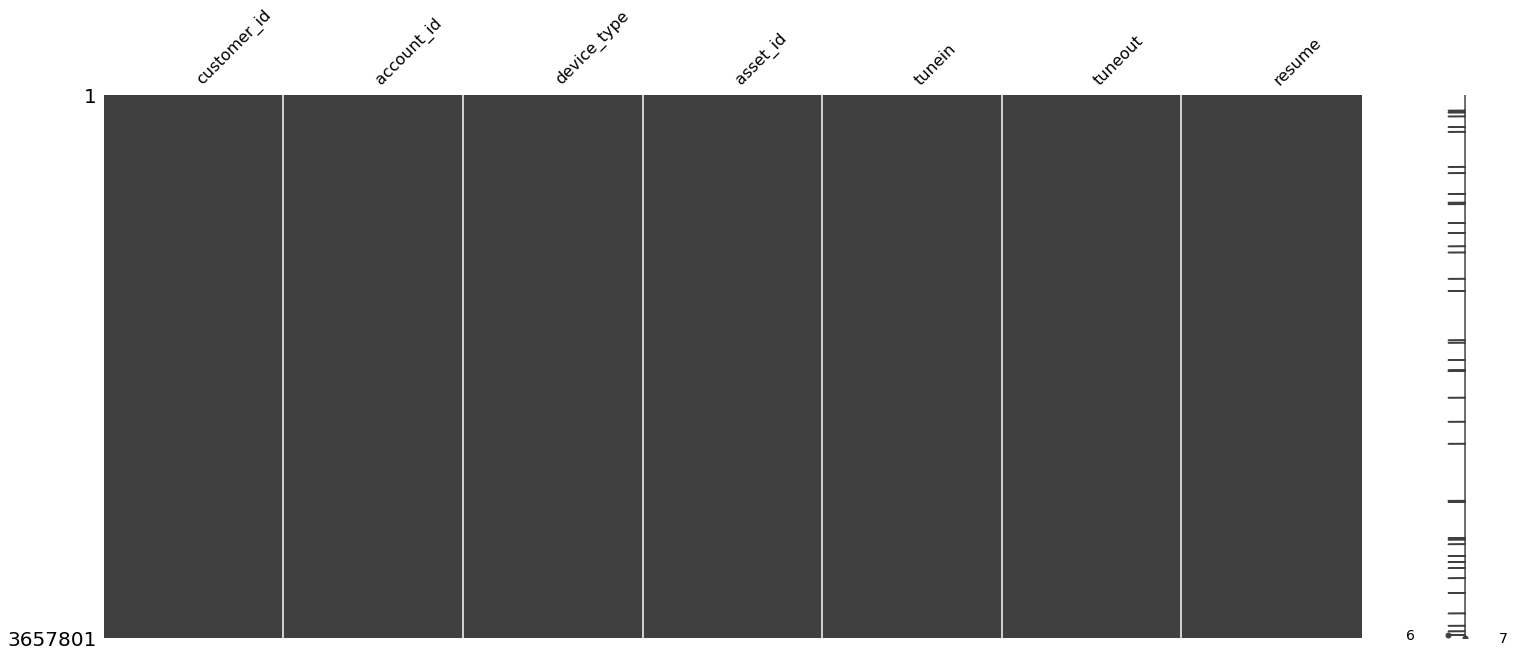

In [ ]:
msno.matrix(train) # demasiados datos para ver los datos faltantes graficamente 

In [ ]:
train.asset_id.isna().sum() 

22

In [ ]:
train.isna().sum()# son muy pocos los datos faltantes por lo tanto se los dropea sin ningun tratamiento

customer_id     0
account_id      0
device_type    29
asset_id       22
tunein          0
tuneout         0
resume          0
dtype: int64

In [ ]:
train=train.dropna()

In [ ]:
train.isna().sum()

customer_id    0
account_id     0
device_type    0
asset_id       0
tunein         0
tuneout        0
resume         0
dtype: int64

In [ ]:
train.asset_id.apply(lambda x : int(x))

0          18332
1          24727
2            895
3            895
4          26062
           ...  
3657796      330
3657797     9931
3657798    29929
3657799    29929
3657800    29929
Name: asset_id, Length: 3657750, dtype: int64

In [ ]:
train.asset_id.nunique() # la cantidad de peliculas es la misma luego de retirar los nan's

23987

### Meta df

In [ ]:
meta.isna().sum() # se eliminan las filas con content_id y show_type de datos faltantes 

asset_id                  0
content_id               21
title                     0
reduced_title             0
episode_title          4147
show_type                 4
released_year             0
country_of_origin         4
category                  0
keywords                  2
description               2
reduced_desc              0
cast_first_name        8732
credits_first_name    12554
run_time_min              0
audience                  1
made_for_tv               0
close_caption             0
sex_rating                0
violence_rating           0
language_rating           0
dialog_rating             0
fv_rating                 0
pay_per_view              0
pack_premium_1            0
pack_premium_2            0
create_date               0
modify_date               0
start_vod_date            0
end_vod_date              0
dtype: int64

In [ ]:
meta.content_id=meta.content_id.fillna('T1')

In [ ]:
meta.loc[meta.content_id=='T1'].index

Int64Index([ 1540,  1541,  1542,  1543,  1544,  1545,  1546, 18197, 18198,
            18199, 18200, 18201, 18202, 18203, 22895, 22896, 22897, 22898,
            22899, 22900, 22901],
           dtype='int64')

In [ ]:
meta=meta.drop(meta.loc[meta.content_id=='T1'].index)

In [ ]:
# Los datos faltantes de content_id son los datos correspondientes a los tutoriales de como usar Flow 

In [ ]:
meta.show_type=meta.show_type.fillna('NoShow')

In [ ]:
meta.loc[meta.show_type=='NoShow']

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,description,reduced_desc,cast_first_name,credits_first_name,run_time_min,audience,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
3187,14004,9,Star Trek: En la oscuridad,Star_Trek__En_la_os,NaN,NoShow,2013.0,US,Acción/Ciencia Ficción,"Aventuras,Saga,Futurismo,Galaxia,Criaturas,Ali...",La tripulación de la nave Enterprise recibe la...,La tripulación de la Enterprise recibe la orde...,"Chris Pine, Zachary Quinto, Zoe Saldana, Bened...",J.J. Abrams,132.0,General,N,N,N,N,N,N,N,N,N,N,2020-11-16T21:16:01.0Z,2020-12-09T17:10:20.0Z,2020-11-20T00:00:00.0Z,2020-12-14T23:59:59.0Z
6421,11154,948,Un verano en pantalones,Un_Verano_En_Pantal,NaN,NoShow,2005.0,US,Comedia,"Mujeres,De Libros,Amigos,Viajes",Cuatro mejores amigas traman un plan para mant...,Cuatro mejores amigas traman un plan para mant...,"Amber Tamblyn, Alexis Bledel, America Ferrera,...",Ken Kwapis,131.0,Mujeres,N,N,N,N,N,N,N,N,N,N,2020-12-29T18:10:46.0Z,2020-12-29T20:06:05.0Z,2020-12-02T00:00:00.0Z,2021-01-01T23:59:00.0Z
7674,27728,9,Star Trek: En la oscuridad,Star_Trek_En_la_DOB,NaN,NoShow,2013.0,US,Acción/Ciencia Ficción,"Aventuras,Saga,Futurismo,Galaxia,Criaturas,Ali...",La tripulación de la nave Enterprise recibe la...,La tripulación de la Enterprise recibe la orde...,"Chris Pine, Zachary Quinto, Zoe Saldana, Bened...",J.J. Abrams,132.0,General,N,N,N,N,N,N,N,N,N,N,2020-12-11T15:09:21.0Z,2020-12-24T15:06:09.0Z,2020-12-15T00:00:00.0Z,2022-11-20T23:59:00.0Z
32927,24509,4315,El día que el deporte se detuvo,El_dia_que_el_depor,NaN,NoShow,2021.0,US,Documental/Deporte,"Pandemias,Deportistas,De Color,Sociedad","Documental original de HBO. Antoine Fuqua, rel...",Documental original de HBO que cuenta la histo...,NaN,Antoine Fuqua,85.0,General,N,N,N,N,N,N,N,N,N,Y,2021-03-29T16:16:36.0Z,2021-03-29T17:06:04.0Z,2021-03-24T00:00:00.0Z,2022-01-10T23:59:00.0Z


In [ ]:
meta.loc[meta.show_type=='NoShow'].index

Int64Index([3187, 6421, 7674, 32927], dtype='int64')

In [ ]:
meta.loc[[3187, 6421, 7674, 32927],'show_type']='Película'

## Peliculas/Series que se termina el contrato antes de poder ser recomendadas

In [ ]:
meta['finserie']=pd.to_datetime(meta.end_vod_date, format='%Y/%m/%d')

In [ ]:
meta['finserie']=meta.finserie.dt.strftime('%Y-%m-%d')

In [ ]:
meta['finserie']=pd.to_datetime(meta.finserie, format='%Y/%m/%d')

In [ ]:
meta.finserie

0       2020-12-01
1       2022-12-14
2       2020-12-01
3       2021-04-30
4       2020-12-31
           ...    
33139   2021-11-20
33140   2021-11-20
33141   2021-03-19
33142   2024-01-28
33143   2021-02-28
Name: finserie, Length: 33123, dtype: datetime64[ns]

In [ ]:
meta.finserie.min()

Timestamp('2020-12-01 00:00:00')

In [ ]:
meta.loc[(meta.finserie <= datetime(year=2021, month=3, day=1))&(meta.show_type=='Serie')]

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,description,reduced_desc,cast_first_name,credits_first_name,run_time_min,audience,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date,finserie
0,15188,0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",Esteban recibe una noticia inesperada: va a se...,Esteban recibe una noticia inesperada: va a se...,"Rodrigo De la Serna, Paola Krum, Fernán Mirás,...",Daniel Barone,48.0,General,N,N,N,N,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z,2020-12-01
6,3619,6,T:1 Ep:04 His Dark Materials,His_Dark_Mat_T1_E04,Armour,Serie,2019.0,GB,Aventura/Fantasía,"Fantasía,De Libros,Criaturas",Lyra y los giptanos llegan al norte y buscan l...,Lyra y los giptanos llegan al norte y buscan l...,"Dafne Keen, Tyler Howitt, Ian Peck, Ruth Wilso...",Otto Bathurst,59.0,Juvenil,N,N,N,N,N,N,N,N,N,Y,2019-11-26T22:52:28.0Z,2019-11-26T23:06:01.0Z,2019-11-26T00:00:00.0Z,2020-12-01T23:59:00.0Z,2020-12-01
8,5066,6,T:1 Ep:05 His Dark Materials,His_Dark_Mat_T1_E05,The Lost Boy,Serie,2019.0,GB,Aventura/Fantasía,"Fantasía,De Libros,Criaturas",El aletiómetro envía a Lyra y a Iorek por un n...,El aletiómetro envía a Lyra y a Iorek por un n...,"Dafne Keen, Tyler Howitt, Ian Peck, Ruta Gedmi...","Otto Bathurst, Tom Hooper",58.0,Juvenil,N,N,N,N,N,N,N,N,N,Y,2019-12-04T12:11:57.0Z,2019-12-04T13:06:01.0Z,2019-12-03T00:00:00.0Z,2020-12-01T23:59:00.0Z,2020-12-01
189,33123,75,T:2 Ep:01 Se rentan cuartos,Se_rentan_cu_T2_E01,La tormenta,Serie,2020.0,MX,Comedia,"Familia,Latinoamérica",En Cilantro 18 se avecina la madre de todas la...,En Cilantro 18 se avecina la madre de todas la...,"Itatí Cantoral, Paco Rueda, Armando Hernández,...",Angeles Roldán,27.0,General,N,N,N,N,N,N,N,N,N,N,2020-05-26T15:59:59.0Z,2020-05-26T16:06:08.0Z,2020-04-01T00:00:00.0Z,2020-12-31T23:59:00.0Z,2020-12-31
190,32896,75,T:2 Ep:02 Se rentan cuartos,Se_rentan_cu_T2_E02,Cita porno,Serie,2020.0,MX,Comedia,"Familia,Latinoamérica",Graciela se da la oportunidad de conocer a un ...,Graciela se da la oportunidad de conocer a un ...,"Itatí Cantoral, Paco Rueda, Armando Hernández,...",Angeles Roldán,32.0,General,N,N,N,N,N,N,N,N,N,N,2020-05-26T17:00:37.0Z,2020-05-26T18:06:02.0Z,2020-05-01T00:00:00.0Z,2020-12-31T23:59:00.0Z,2020-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11290,1162,1797,Ep:021 ¿Qué culpa tiene? Fatmagül,Fatmagul_E021,Episodio 21,Serie,2010.0,TR,Drama,"Melodrama,De Libros",¿Quién es la mujer que está siguiendo a Fatmagül?,Fatmagül vive con su hermano en un humilde pue...,"Beren Saat, Engin Akyürek, Fırat Çelik, Murat ...",NaN,71.0,Mujeres,N,N,N,N,N,N,N,N,N,N,2021-01-05T14:26:00.0Z,2021-01-05T15:06:05.0Z,2021-01-04T00:00:00.0Z,2021-03-01T23:59:00.0Z,2021-03-01
11291,9878,1797,Ep:022 ¿Qué culpa tiene? Fatmagül,Fatmagul_E022,Episodio 22,Serie,2010.0,TR,Drama,"Melodrama,De Libros",Mukaddes intenta convencer a Fatmagül para que...,Fatmagül vive con su hermano en un humilde pue...,"Beren Saat, Engin Akyürek, Fırat Çelik, Murat ...",NaN,66.0,Mujeres,N,N,N,N,N,N,N,N,N,N,2021-01-12T12:30:06.0Z,2021-01-12T13:06:01.0Z,2021-01-11T00:00:00.0Z,2021-03-01T23:59:00.0Z,2021-03-01
11296,31142,698,T:23 Ep:15 Viajes Pokémon,Viajes_Poke_T23_E15,¡Un día de búsqueda en la nieve!,Serie,2020.0,JP,Infantil/Animación,"Criaturas,Aventuras,Fantasía,Amigos",La nieve obliga al Profesor Cerise a cerrar te...,¡Un clima nevado le da a Goh la oportunidad de...,NaN,NaN,21.0,Niños,N,N,N,N,N,N,N,N,N,N,2021-01-27T18:07:33.0Z,2021-01-27T21:06:06.0Z,2021-01-12T00:00:00.0Z,2021-03-01T23:59:00.0Z,2021-03-01
11323,595,176,Ep:081 Moisés,Moises_E081,Episodio 81,Serie,2015.0,BR,Dr

In [ ]:
meta.loc[(meta.finserie <= datetime(year=2021, month=3, day=1))].asset_id.nunique() # Se elige el mes 3 porque se entiende que no van  a estar para cuando el sist de recomendacion este en funcionamiento 

10713

In [ ]:
debaja=meta.loc[(meta.finserie <= datetime(year=2021, month=3, day=1))].asset_id.unique()# se ve que son muchas peliculas/series que quedan afuera casi la mitad

In [ ]:
debaja2=meta.loc[(meta.finserie <= datetime(year=2021, month=3, day=1))].index

In [ ]:
debajaind=train.loc[train.asset_id.isin(debaja)].index

In [ ]:
meta=meta.drop(debaja2)

In [ ]:
train=train.drop(debajaind)#se elimeninan las filas con dichas peliculas/series pasando de 3.600.000 a 3.300.000

## Evaluación de content_id con relación a series. 

In [ ]:
meta.content_id.nunique()

3492

In [ ]:
meta.show_type.unique()

array(['Película', 'TV', 'Serie', 'Gaming', 'Web', 'Rolling',
       'Series,Serie'], dtype=object)

In [ ]:
for x in meta.show_type.unique():
  print(f'En {x} hay: {meta.loc[(meta.show_type==x)].asset_id.nunique()} asset_id')
  print(f'En {x} hay: {meta.loc[(meta.show_type==x)].content_id.nunique()} content_id')
  print(f'Relación A/C:{meta.loc[(meta.show_type==x)].asset_id.nunique()/meta.loc[(meta.show_type==x)].content_id.nunique()}\n')

En Película hay: 2806 asset_id
En Película hay: 2466 content_id
Relación A/C:1.137875101378751

En TV hay: 9454 asset_id
En TV hay: 549 content_id
Relación A/C:17.22040072859745

En Serie hay: 8689 asset_id
En Serie hay: 383 content_id
Relación A/C:22.68668407310705

En Gaming hay: 534 asset_id
En Gaming hay: 32 content_id
Relación A/C:16.6875

En Web hay: 789 asset_id
En Web hay: 67 content_id
Relación A/C:11.776119402985074

En Rolling hay: 136 asset_id
En Rolling hay: 7 content_id
Relación A/C:19.428571428571427

En Series,Serie hay: 2 asset_id
En Series,Serie hay: 1 content_id
Relación A/C:2.0



In [ ]:
meta.loc[(meta.show_type=='Serie')|(meta.show_type=='TV')|(meta.show_type=='Series,Serie')] # se puede ver que los asset_id son diferentes aunque refieran a la misma serie 

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,description,reduced_desc,cast_first_name,credits_first_name,run_time_min,audience,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date,finserie
5,17760,5,T:2 Ep:06 Gaycation,Gaycation_T2_E06,United we stand,TV,2017.0,US,Documental/Cultura,"LGBT,Sociedad,Cultura,Feminismo","En esta presentación especial de Gaycation, El...","En esta presentación especial de Gaycation, El...","Ellen Page, Ian Daniel",Niharika Desai,44.0,Juvenil,N,N,N,N,N,N,N,N,N,N,2019-06-27T14:20:42.0Z,2019-11-02T03:16:48.0Z,2019-06-27T00:00:00.0Z,2021-07-27T23:59:59.0Z,2021-07-27
145,31393,39,09/01 - Sportia,Sportia_01-09,1 Septiembre 2020,TV,2020.0,AR,Interés General/Deporte,"Fútbol,Periodístico Deportivo",El noticiero de TyC Sports con toda la informa...,El noticiero de TyC Sports con toda la informa...,"Cristian Garofalo, Juan Martín Rinaldi, María ...",NaN,149.0,Hombres,N,N,N,N,N,N,N,N,N,N,2020-09-02T19:07:28.0Z,2020-09-02T20:06:02.0Z,2020-09-02T00:00:00.0Z,2021-09-16T23:59:00.0Z,2021-09-16
151,24801,39,09/02 - Sportia,Sportia_02-09,2 Septiembre 2020,TV,2020.0,AR,Interés General/Deporte,"Fútbol,Periodístico Deportivo",El noticiero de TyC Sports con toda la informa...,El noticiero de TyC Sports con toda la informa...,"Cristian Garofalo, Juan Martín Rinaldi, María ...",NaN,149.0,Hombres,N,N,N,N,N,N,N,N,N,N,2020-09-03T17:50:59.0Z,2020-09-03T18:06:04.0Z,2020-09-03T00:00:00.0Z,2021-09-17T23:59:00.0Z,2021-09-17
184,16417,72,11/27 - Te Quiero Diego,Te_Quiero_D_27-11,27 Noviembre 2020,TV,2020.0,AR,Magazine/Biografía,"Actualidad,Celebridades,Biografía,Fútbol,Marad...",Un programa especial en vivo con un repaso por...,Un programa especial con un repaso por los mej...,Diego Armando Maradona,NaN,75.0,General,N,N,N,N,N,N,N,N,N,N,2020-11-28T23:14:01.0Z,2020-11-29T00:06:14.0Z,2020-11-28T00:00:00.0Z,2021-05-27T23:59:00.0Z,2021-05-27
261,5344,89,T:1 Ep:01 Guille Aquino - Manijomio,Guille_Aquin_T1_E01,Lo Mejor del Sketch Vol. 1,Serie,2020.0,AR,Comedia,"Política,Actualidad,Humor Negro,Parodia,Tragic...",Guille Aquino le juega la revancha al 2020 y n...,Guille Aquino le juega la revancha al 2020 y n...,Guille Aquino,NaN,28.0,Juvenil,N,N,N,N,N,N,N,N,N,N,2020-11-28T21:17:29.0Z,2020-11-28T23:06:07.0Z,2020-11-27T00:00:00.0Z,2023-11-27T23:59:00.0Z,2023-11-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33136,9095,1979,T:1 Ep:02 Allen V. Farrow,Allen_V_Far_T1_E02,Episodio 2,Serie,2021.0,US,Drama/Documental,"Abusos,Familia,Juicio,Hechos Reales,Miniserie",Mientras Mía y Woody ascienden como pareja en ...,Surgen revelaciones sobre la relación de Allen...,"Mia Farrow, Woody Allen, Dylan Farrow, Ronan F...",Dick Kirby,62.0,General,N,N,N,N,N,N,N,N,N,Y,2021-03-28T23:38:23.0Z,2021-03-29T00:06:05.0Z,2021-02-28T00:00:00.0Z,2021-11-20T23:59:00.0Z,2021-11-20
33139,3683,1979,T:1 Ep:03 Allen V. Farrow,Allen_V_Far_T1_E03,Episodio 3,Serie,2021.0,US,Drama/Documental,"Abusos,Familia,Juicio,Hechos Reales,Miniserie",Mientras Mia intenta proteger a Dylan del trau...,El equipo legal y de relaciones públicas de Al...,"Mia Farrow, Woody Allen, Dylan Farrow, Ronan F...",Dick Kirby,64.0,General,N,N,N,N,N,N,N,N,N,Y,2021-03-28T23:39:28.0Z,2021-03-29T00:06:09.0Z,2021-03-07T00:00:00.0Z,2021-11-20T23:59:00.0Z,2021-11-20
33140,16810,1979,T:1 Ep:01 Allen V. Farrow,Allen_V_Far_T1_E01,Episodio 1,Serie,2021.0,US,Drama/Documental,"Abusos,Familia,Juicio,Hechos Reales,Miniserie",Mia Farrow habla sobre su relación con Woody A...,Mia Farrow habla sobre su relación con Woody A...,"Mia Farrow, Woody Allen, Dylan Farrow, Ronan F...",Dick Kirby,56.0,General,N,N,N,N,N,N,N,N,N,Y,2021-03-28T23:37:17.0Z,2021-03-29T00:06:01.0Z,2021-02-21T00:00:00.0Z,2021-11-20T23:59:00.0Z,2021-11-20
33141,20468,943,T:2 E

In [ ]:
meta.loc[meta.show_type=='Serie'].asset_id.nunique()# todas las filas corresponden a un valor 

8689

In [ ]:
meta.loc[meta.show_type=='Serie'].content_id.nunique()#código de identificación que agrupa los distintos asset_id asociados a un mismo contenido (por ejemplo, cada episodio de una misma serie tiene su propio asset_id, mientras que la serie se identifica con un content_id único)

383

In [ ]:
content=meta.loc[meta.show_type=='Serie'].content_id.unique()

In [ ]:
content


array([89.0, 97.0, 113.0, 116.0, 167.0, 177.0, 387.0, 423.0, 0.0, 624.0,
       393.0, 509.0, 510.0, 670.0, 555.0, 674.0, 675.0, 676.0, 729.0,
       1140.0, 1364.0, 1406.0, 1422.0, 1531.0, 1538.0, 1621.0, 1836.0,
       115.0, 1845.0, 698.0, 1879.0, 1898.0, 1899.0, 1909.0, 1910.0,
       1920.0, 176.0, 1957.0, 1978.0, 1979.0, 1982.0, 1983.0, 1984.0,
       1985.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2005.0, 1611.0,
       122.0, 2012.0, 2013.0, 119.0, 2016.0, 2017.0, 2022.0, 2023.0,
       817.0, 2024.0, 120.0, 2028.0, 2032.0, 1539.0, 691.0, 1629.0,
       2034.0, 1625.0, 2038.0, 2040.0, 117.0, 2041.0, 2042.0, 2043.0,
       2044.0, 2045.0, 2046.0, 2048.0, 121.0, 1573.0, 1021.0, 2052.0,
       2054.0, 2056.0, 2060.0, 2077.0, 1523.0, 2086.0, 2091.0, 2093.0,
       2094.0, 2095.0, 2098.0, 909.0, 2100.0, 2101.0, 2120.0, 2121.0,
       2127.0, 2129.0, 2131.0, 2134.0, 2135.0, 1097.0, 2140.0, 2144.0,
       2145.0, 2148.0, 2152.0, 2153.0, 2159.0, 2161.0, 2162.0, 2165.0,
       2167.0, 2

In [ ]:
seriesc=meta.loc[meta.show_type=='Serie'].asset_id.unique()

In [ ]:
train.loc[train.asset_id.isin(seriesc)] # vemos que 1.4 millones de filas se corresponden con los asset_id de las series lo que se estaria repitiendo mucho con una misma serie

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0
...,...,...,...,...,...,...,...
3657429,112338,82934,CLOUD_CLIENT,18332.0,2021-02-23 22:30:00.0,2021-02-23 22:46:00.0,0
3657430,112338,82934,CLOUD_CLIENT,18332.0,2021-02-27 14:18:00.0,2021-02-27 14:40:00.0,0
3657433,112338,82934,CLOUD_CLIENT,24727.0,2021-03-18 20:03:00.0,2021-03-18 20:14:00.0,0
3657434,112338,82934,CLOUD_CLIENT,24727.0,2021-03-18 20:14:00.0,2021-03-18 20:53:00.0,0


In [ ]:
meta.loc[meta.asset_id.isin(content)] #content_id ya esta en unso en asset_id por lo tanto no se podra utilizar el codigo de content en asset

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,description,reduced_desc,cast_first_name,credits_first_name,run_time_min,audience,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date,finserie
733,2100,178,T:1 Ep:20 El Día Que con Magnus Mefisto - Mani...,El_Dia_Que_c_T1_E20,El día que murió Maradona,TV,2020.0,AR,Entretenimiento,"Historia,Narcos,Mafia,Crimen","D10S, El Die, Diegote, Pelusa. 60 años en la v...","D10S, El Die, Diegote, Pelusa. 60 años en la v...",Magnus Mefisto,NaN,16.0,Juvenil,N,N,N,N,N,N,N,N,N,N,2020-12-09T18:38:00.0Z,2020-12-09T20:06:08.0Z,2020-12-08T00:00:00.0Z,2023-12-08T23:59:00.0Z,2023-12-08
819,2405,184,T:1 Ep:53 Viví tu viaje,Vivi_tu_viaj_T1_E53,Róterdam: La ciudad del diseño y la arquitectura,TV,2019.0,AR,Documental/Viajes,"Viajes,Cultura,Historia,Europa,Latinoamérica,Á...",Recorremos los grandes imperdibles arquitectón...,Recorremos los grandes imperdibles arquitectón...,NaN,NaN,3.0,General,N,N,N,N,N,N,N,N,N,N,2020-11-02T00:07:40.0Z,2020-11-02T00:07:40.0Z,2020-12-15T00:00:00.0Z,2030-02-04T23:59:59.0Z,2030-02-04
833,3533,185,T:1 Ep:08 Viví tu viaje: Grandes ciudades,Vivi_tu_viaj_T1_E08,Dubai,TV,2019.0,AR,Documental/Viajes,"Viajes,Cultura,Historia,Europa,Latinoamérica,V...",Guía de viaje recorriendo los imperdibles de D...,Guía de viaje recorriendo los imperdibles de D...,NaN,NaN,5.0,General,N,N,N,N,N,N,N,N,N,N,2020-11-02T00:54:00.0Z,2020-11-02T00:54:00.0Z,2020-12-15T00:00:00.0Z,2030-02-04T23:59:59.0Z,2030-02-04
3402,3480,0,Ep:22 Tiempos compulsivos,Tiempos_Compul_E22,Episodio 22,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",Esteban atravesó momentos difíciles: su enferm...,Esteban atravesó momentos difíciles: su enferm...,"Rodrigo De la Serna, Paola Krum, Fernán Mirás,...",Daniel Barone,37.0,General,N,N,N,N,N,N,N,N,N,N,2020-12-10T16:08:38.0Z,2020-12-10T16:08:38.0Z,2020-12-15T00:00:00.0Z,2030-12-01T23:59:59.0Z,2030-12-01
3455,2269,624,T:1 Ep:05 Historias veterinarias,Historias_ve_T1_E05,Susana y Lola,Serie,2020.0,AR,Documental/Animales,"Mascotas,Animales,Veterinarios,Flow",La vejes trae consigo el entendimiento de que ...,La vejes trae consigo el entendimiento de que ...,Dr. Juan Romero,"Mariano Hueter, Juan Irigoyen",25.0,General,N,N,N,N,N,N,N,N,N,N,2020-11-20T05:00:49.0Z,2020-11-25T01:06:05.0Z,2020-11-25T00:00:00.0Z,2030-11-25T23:59:00.0Z,2030-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32510,4155,57,T:1 Ep:16 Marvel Spider-Man,Marvel_Spide_T1_E16,El surgimiento de Doc Ock - Primera parte,TV,2017.0,US,Infantil/Dibujos Animados,"Marvel,Comics,Superhéroes",Después de que una explosión fusiona los brazo...,"Peter Parker, un nuevo estudiante en el famoso...",NaN,NaN,24.0,Teens,N,N,N,N,N,N,N,N,N,N,2021-03-23T20:33:41.0Z,2021-03-24T02:06:08.0Z,2021-03-23T00:00:00.0Z,2021-04-22T23:59:00.0Z,2021-04-22
32686,624,4170,T:1 Ep:11 Física o química,Fisica_o_qui_T1_E11,Una cuestión de equilibrio,Serie,2008.0,ES,Drama/Romance,"Adolescentes,Instituto,Europa",Irene consigue un nuevo trabajo en una tienda ...,Irene consigue un nuevo trabajo en una tienda ...,"Ana Milán, Andrea Duro, Javier Calvo, Úrsula C...",Carlos Montero,74.0,General,N,N,N,N,N,N,N,N,N,N,2021-03-25T16:36:34.0Z,2021-03-25T16:36:34.0Z,2021-03-31T00:00:00.0Z,2022-04-30T23:59:59.0Z,2022-04-30
32772,2045,1041,T:1 Ep:26 Manzana y Cebollín,Manzana_y_Ce_T1_E26,Sigue tus sueños,TV,2017.0,US,Infantil/Dibujos Animados,"Ingenioso,Amigos",Manzana y Cebollín necesitan encontrar un sueñ...,Manzana y Cebollín necesitan encontrar un sueñ...,"Sayed Badreya, Richard Ayoade, George Gendi",Benton Connor,11.0,Teens,N,N,N,N,N,N,N,N,N,N,2021-03-25T22:30:51.0Z,2021-03-26T00:06:13.0Z,2021-03-01T00:00:00.0Z,2021-03-31T23:59:00.0Z,2021-03-31
32867,2145,4313,Jack Rea

In [ ]:
meta.content_id.nunique()

3492

# Nueva designación.

In [ ]:
pd.to_numeric(meta.content_id)

1           1.0
3           3.0
5           5.0
10          9.0
142        36.0
          ...  
33138    4260.0
33139    1979.0
33140    1979.0
33141     943.0
33142    1957.0
Name: content_id, Length: 22410, dtype: float64

In [ ]:
%%time
train['content_id']=0 # tarda ~5 min 
for x in meta.content_id.unique():
  a=meta.loc[meta.content_id== x].asset_id.unique()
  b=train.loc[train.asset_id.isin(a)].index
  train.loc[b , 'content_id']= x

CPU times: user 3min 13s, sys: 2.09 s, total: 3min 15s
Wall time: 3min 14s


In [ ]:
train.content_id.nunique() # hay un contenido que no lo ha visto nadie ya que el conten_id de meta es mayor que e l de train.

3454

In [ ]:
train.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0,2040
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0,2040
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0,1983
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1,1983
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0,729


In [ ]:
train.content_id.dtype

dtype('int64')

In [ ]:
train.content_id.isna().sum()

0

# Resumiendo 


*   Se cargaron los datos 
*   se evaluaron los datos faltantes, sobretodo en las columnas de show_type en donde se renombraron a peliculas, y en content_id los cuales los datos faltantes tenian que ver con los tutoriales para manejar la app.Estos ulimos se eliminaron del sist de recomendacion. Capaz que se puedan poner para los usuarios que recien comienzan a utilizar la app.

*   Se eliminaron tanto del dataframe de train como de meta las peliculas/series cuyo contrato termina en Marzo del 2021.
*   se vio la relacion de content_id con respecto a asset_id y se determino que content_id hace referencia al programa en si. Mientras que asset_id a los diferentes capitulos. Por lo tanto hace logica recomendar por content_id y no recomendar por capitulos (asset_id).
* por ultimo se mapeo cada asset_id del dataframe de train con su respectivo content_id.





# Desarrollo del modelo final - inclusión de la variable tiempo de observacion -

## Procesamiento de datos

In [ ]:
train.shape

(3354921, 8)

In [ ]:
train.head()


,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0,2040
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0,2040
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0,1983
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1,1983
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0,729


In [ ]:
col_a_util=['account_id', 'content_id','tunein','tuneout']

In [ ]:
train2= train[col_a_util].copy()

In [ ]:
train2.head()

,account_id,content_id,tunein,tuneout
0,90627,2040,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0
1,90627,2040,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0
2,3387,1983,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0
3,3387,1983,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0
4,3387,729,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0


In [ ]:
train2.tunein=pd.to_datetime(train2.tunein, format='%Y/%m/%d')

In [ ]:
train2.tunein.dtype

dtype('<M8[ns]')

In [ ]:
train2['YMD']=train2.tunein.dt.strftime('%Y-%m-%d')

In [ ]:
train2.YMD

0          2021-02-18
1          2021-03-24
2          2021-03-15
3          2021-03-15
4          2021-03-16
              ...    
3657796    2021-03-31
3657797    2021-03-31
3657798    2021-03-31
3657799    2021-03-31
3657800    2021-03-31
Name: YMD, Length: 3354921, dtype: object

In [ ]:
train2.YMD=pd.to_datetime(train2.YMD , format='%Y/%m/%d')

In [ ]:
train2.tuneout=pd.to_datetime(train2.tuneout, format='%Y/%m/%d')

In [ ]:
train2['tvisto']=train2.tuneout-train2.tunein #obtenemos la diferencia, es decir el tiempo visto.

In [ ]:
train2.tvisto= train2.tvisto.apply(lambda x : str(x) ) #Los pasamos a str para poder realizar  un split

In [ ]:
train2.tvisto 

0          0 days 00:43:00
1          0 days 00:44:00
2          0 days 00:18:00
3          0 days 00:55:00
4          0 days 00:20:00
                ...       
3657796    0 days 00:12:00
3657797    0 days 00:12:00
3657798    0 days 00:12:00
3657799    0 days 00:04:00
3657800    0 days 00:11:00
Name: tvisto, Length: 3354921, dtype: object

In [ ]:
train2.tvisto= train2.tvisto.apply(lambda x : x.split(':',2)[1] ) #nos quedamos con los minutos 

In [ ]:
train2.tvisto.head()

0    43
1    44
2    18
3    55
4    20
Name: tvisto, dtype: object

In [ ]:
train2.tvisto.astype(int) # Los pasamos de str a int.

0          43
1          44
2          18
3          55
4          20
           ..
3657796    12
3657797    12
3657798    12
3657799     4
3657800    11
Name: tvisto, Length: 3354921, dtype: int64

In [ ]:
train2.head()

,account_id,content_id,tunein,tuneout,YMD,tvisto
0,90627,2040,2021-02-18 22:52:00,2021-02-18 23:35:00,2021-02-18,43
1,90627,2040,2021-03-24 23:17:00,2021-03-25 00:01:00,2021-03-24,44
2,3387,1983,2021-03-15 10:05:00,2021-03-15 10:23:00,2021-03-15,18
3,3387,1983,2021-03-15 10:23:00,2021-03-15 11:18:00,2021-03-15,55
4,3387,729,2021-03-16 09:24:00,2021-03-16 09:44:00,2021-03-16,20


In [ ]:
train2.tuneout.head()

0   2021-02-18 23:35:00
1   2021-03-25 00:01:00
2   2021-03-15 10:23:00
3   2021-03-15 11:18:00
4   2021-03-16 09:44:00
Name: tuneout, dtype: datetime64[ns]

In [ ]:
train2.tvisto=train2.tvisto.astype(int)

In [ ]:
train2.loc[(train2.account_id == 2) & (train2.content_id == 6 )].index

Int64Index([3167232, 3167248, 3167249, 3167251], dtype='int64')

In [ ]:
train2.loc[3167232, 'tvisto'].mean()

7.0

In [ ]:
train2.loc[train2.account_id == 2 ].content_id.unique()

array([   6,  557, 1582,  433])

In [ ]:
train2.account_id.unique()


array([90627,  3387,  3388, ...,  3385, 82934,  3386])

In [ ]:
train2.loc[[3167232, 3167248, 3167249, 3167251]]

,account_id,content_id,tunein,tuneout,YMD,tvisto
3167232,2,6,2021-01-03 20:44:00,2021-01-03 21:51:00,2021-01-03,7
3167248,2,6,2021-01-20 18:52:00,2021-01-20 19:47:00,2021-01-20,55
3167249,2,6,2021-01-20 21:51:00,2021-01-20 22:46:00,2021-01-20,55
3167251,2,6,2021-01-20 22:46:00,2021-01-20 23:42:00,2021-01-20,56


In [ ]:
train2.head()

,account_id,content_id,tunein,tuneout,YMD,tvisto
0,90627,2040,2021-02-18 22:52:00,2021-02-18 23:35:00,2021-02-18,43
1,90627,2040,2021-03-24 23:17:00,2021-03-25 00:01:00,2021-03-24,44
2,3387,1983,2021-03-15 10:05:00,2021-03-15 10:23:00,2021-03-15,18
3,3387,1983,2021-03-15 10:23:00,2021-03-15 11:18:00,2021-03-15,55
4,3387,729,2021-03-16 09:24:00,2021-03-16 09:44:00,2021-03-16,20


## Divisón en train y test





In [ ]:
train3=train2.loc[(train2.tunein <= datetime(year=2021, month=3, day=1))].copy()

In [ ]:
test2=train2.loc[(train2.tunein >= datetime(year=2021, month=3, day=1))].copy()

## Greneracion de la vas variables long y dif.

In [ ]:
train3['long']=0

for cont in tqdm.tqdm(meta.content_id.unique()):
  inde=train3.loc[train3.content_id == cont].index 
  train3.loc[inde, 'long']=round(meta.loc[meta.content_id == cont].run_time_min.median())

100%|██████████| 3492/3492 [01:27<00:00, 39.84it/s]


In [ ]:
train3.head()

,account_id,content_id,tunein,tuneout,YMD,tvisto,long
0,90627,2040,2021-02-18 22:52:00,2021-02-18 23:35:00,2021-02-18,43,42
6,3388,2100,2021-01-01 02:22:00,2021-01-01 02:34:00,2021-01-01,12,43
7,3388,2100,2021-01-02 01:02:00,2021-01-02 01:08:00,2021-01-02,6,43
8,3388,2100,2021-01-02 01:08:00,2021-01-02 01:21:00,2021-01-02,13,43
9,3388,2100,2021-01-04 01:32:00,2021-01-04 01:35:00,2021-01-04,3,43


In [ ]:
train3['dif']=train3.tvisto/train3.long

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


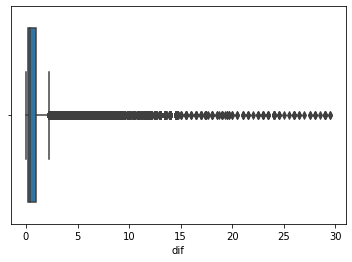

In [ ]:
sns.boxplot(train3.dif)
plt.show()

In [ ]:
def unos(df, x ):
  for c in df.index:
    if (df.loc[c, 'tvisto'] >= df.loc[c, 'long']):
      x=1
    return x

In [ ]:
train3.dif.apply(lambda x : unos(train3 , x))

0          1
6          1
7          1
8          1
9          1
          ..
3657519    1
3657520    1
3657521    1
3657522    1
3657523    1
Name: dif, Length: 2036896, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


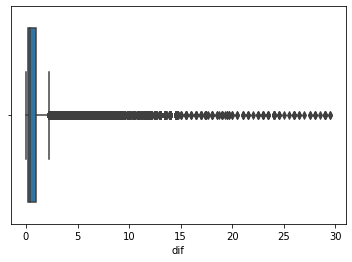

In [ ]:
sns.boxplot(train3.dif)
plt.show()

In [ ]:
train3.loc[train3.loc[train3.dif>=1].index, 'dif']=1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


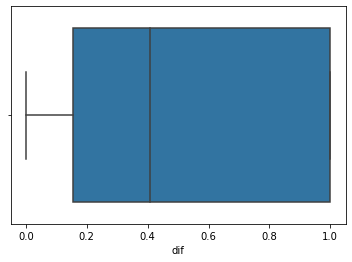

In [ ]:
sns.boxplot(train3.dif)
plt.show()

In [ ]:
train3=train3.groupby(['content_id','account_id'], as_index=False).agg({'dif':'median', 'tvisto':'mean','long':'mean'})

In [ ]:
top10v=train3.groupby('content_id',as_index= False).agg({'tvisto':'sum'}).sort_values(by = 'tvisto', ascending=False).head(10)

## Eda de los contenidos vistos 

El contenido mas tiempo visto

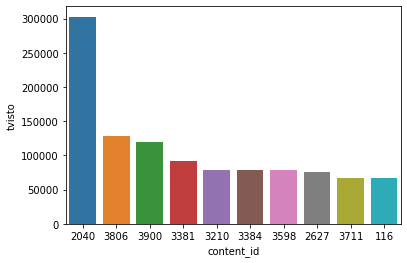

In [ ]:
sns.barplot(x=top10v.content_id, y=top10v.tvisto, order=top10v.loc[top10v.tvisto.sort_values(ascending=False).index].content_id.values)
plt.show()

In [ ]:
top10l=train3.groupby('content_id',as_index= False).agg({'long':'sum'}).sort_values(by = 'long', ascending=False).head(10)

In [ ]:
top10l

,content_id,long
2804,3806,578292
1059,2040,482202
2552,3550,462978
2387,3381,408330
2600,3598,380972
2390,3384,355652
1979,2972,343680
2216,3210,337928
562,724,324750
2709,3711,298248


Longitud del contenido

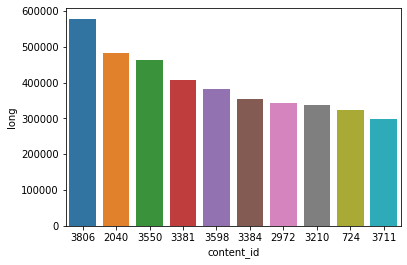

In [ ]:
sns.barplot(x=top10l.content_id, y=top10l.long, order=top10l.loc[top10l.long.sort_values(ascending=False).index].content_id.values)
plt.show()

Vemos que la longitud del contenido casi que no cambia en el primer contenido (2040) es una serie muy vista y larga por lo que podemos observar.
Los contenidos sucesivos cambiand de ranking , pero se mantienen dentro del top 10 de contenido mas tiempo visto. 

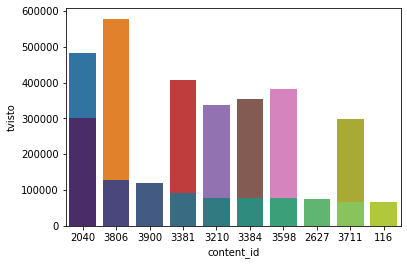

In [ ]:
sns.barplot(x=top10l.content_id, y=top10l.long, order=top10v.loc[top10v.tvisto.sort_values(ascending=False).index].content_id.values )
sns.barplot(x=top10v.content_id, y=top10v.tvisto, order=top10v.loc[top10v.tvisto.sort_values(ascending=False).index].content_id.values,palette ="viridis")

plt.show()

Podemos comparar la longitud del contenido con lo visto, y pareciera que en general la gente no consume todo el capitulo, o muchos entran a ver  el capitulo y deciden que es suficiente.

La mayoria de los contendios Son series exepto el cont. 3806.Es una pelicula (Cosas de minas).El cual es uno de los contenidos mas vistos. junto con fuga de pretoria , tengo gans de ti y Ip Man 4 

La mas interesante es 3900 la cual tiene una relacion de tiempo visto y duracion mayor que las demas.


Nombre de los contenidos mas vistos 

In [ ]:
los=[]
for x in (top10v.loc[top10v.tvisto.sort_values(ascending=False).index].content_id.values) :
  los.append(meta.loc[meta.content_id==x].title.values[0])
  
for l in los :
  print(l)

T:1 Ep:01 This is Us
Cosa de minas
T:1 Ep:01 The Collapse
3 metros sobre el cielo
Fuga de pretoria
Tengo ganas de ti
Badur hogar
T:1 Ep:01 La vida prometida
Ip Man 4
T:1 Ep:04 The Undoing


## Obtención de la matriz

In [ ]:
train3.dif=train3.dif.apply(lambda x : round(x,2))

In [ ]:
train3.tvisto=train3.tvisto.apply(lambda x : round(x,2))

In [ ]:
train_piv=train3.pivot(index="account_id", columns="content_id", values="dif")

In [ ]:
train_piv.shape


(97509, 3017)

Se eliminan peliculas poco vistas para simplificar el modelo.

In [ ]:
train_piv=train_piv.dropna(thresh=10 , axis=1).fillna(0) 

In [ ]:
train_piv.head()

content_id,0,1,3,6,7,8,9,18,19,20,22,23,24,26,33,36,37,38,39,40,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,66,...,4326,4327,4328,4329,4330,4331,4332,4333,4334,4335,4336,4337,4338,4339,4340,4341,4343,4344,4345,4346,4347,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4358,4359,4360,4361,4362,4363,4364,4365,4366
account_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_piv.shape

(97509, 2660)

In [ ]:
train_piv_csr = csr_matrix(train_piv.values)

In [ ]:
train_piv_csr

<97509x2660 sparse matrix of type '<class 'numpy.float64'>'
	with 586564 stored elements in Compressed Sparse Row format>

## Geración y entrenamiento del modelo

In [ ]:
modelo1= LightFM(no_components=100, random_state=100, learning_rate=0.03, loss='warp')

In [ ]:
%%time

modelo = modelo1.fit(train_piv_csr, epochs=100,
                  num_threads=16, verbose=True)

Epoch: 100%|██████████| 100/100 [03:42<00:00,  2.23s/it]

CPU times: user 7min 10s, sys: 506 ms, total: 7min 11s
Wall time: 3min 43s


In [ ]:
item_id = list(train_piv.columns)
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

In [ ]:
user_ids = list(train_piv.index)
user_dict = {}
counter = 0 
for i in user_ids:
    user_dict[i] = counter
    counter += 1

In [ ]:
def recomm(model, interactions, user_id, user_dict, item_dict, nrec_items = 10, show = True):

    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]

    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                [interactions.loc[user_id,:] > 0].index).sort_values(ascending=False))
    
    #Filtro de items que ya vió el usuario
    scores = [x for x in scores if x not in known_items]
    recomms = scores[0:nrec_items]

    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + str(i))
            counter+=1

        print("\n Recommended Items:")
        
        counter = 1
        for i in recomms:
            print(str(counter) + '- ' + str(i))
            counter+=1

    return recomms

## Cold Start recomms

In [ ]:
cold_start_recomms =   train3\
                      .groupby("content_id")\
                      .agg({"dif": "sum"})\
                      .sort_values(by="dif", ascending=False)\
                      .head(20)\
                      .index\
                      .to_list()

In [ ]:
los=[]
for x in cold_start_recomms :
  los.append(meta.loc[meta.content_id==x].title.values[0])
  
for l in los :
  print(l)

T:1 Ep:01 This is Us
T:1 Ep:01 The Collapse
T:1 Ep:01 Paw Patrol, Patrulla Canina
Cosa de minas
T:7 Ep:08 Peppa Pig
T:1 Ep:01 Bluey
T:1 Ep:01 Mi amigo hormiga
T:1 Ep:01 ALT ESC
T:3 Ep:01 Famoso
T:1 Ep:01 La Granja de Zenón
T:1 Ep:01 La vida prometida
T:1 Ep:01 Los visitantes
T:2 Ep:78 Puppy Dog Pals
T:2 Ep:63 Vampirina
T:4 Ep:96 Junior Express
T:1 Ep:04 The Undoing
T:1 Ep:01 The Fall
T:1 Ep:01 Stand Up Argentina
T:1 Ep:01 The Outpost
T:17 Ep:01 Grey's Anatomy


##Metricas del modelo 

In [ ]:
users = train.account_id.unique()
non_cold_users = train3.account_id.unique()

print(len(users), len(non_cold_users))

112755 97509


In [ ]:
print(f"El porcentaje de cold start users es : {round((len(users)-len(non_cold_users))/len(users)*100,2)}% ")

El porcentaje de cold start users es : 13.52% 


In [ ]:
recomms_dict = {
    "user": [],
    "recomms": [],
    "cold": []
}

for user in tqdm.tqdm(users):
  
  # Recomms personalizadas
  if user in non_cold_users:
    user_recomms = recomm(modelo1, train_piv , user, user_dict, item_dict, nrec_items = 20, show = False)
    recomms_dict["user"].append(user)
    recomms_dict["recomms"].append(user_recomms)
    recomms_dict["cold"].append(False) #Para luego tener identificados a los usuarios cold
  
  # Recomms cold
  else:
    recomms_dict["user"].append(user)
    recomms_dict["recomms"].append(cold_start_recomms)
    recomms_dict["cold"].append(True) #Para luego tener identificados a los usuarios cold

100%|██████████| 112755/112755 [08:04<00:00, 232.65it/s]


In [ ]:
recomms_df = pd.DataFrame(recomms_dict)

In [ ]:
recomms_df.head()

,user,recomms,cold
0,90627,"[116, 3578, 724, 1898, 1539, 1140, 97, 2641, 1...",False
1,3387,"[2040, 3900, 2160, 3806, 1316, 1139, 3775, 372...",True
2,3388,"[97, 724, 2383, 1898, 3752, 2044, 2408, 2946, ...",False
3,3389,"[3097, 3234, 3783, 3182, 3566, 2177, 2012, 308...",False
4,3390,"[1008, 3697, 3213, 3711, 2901, 3732, 3262, 353...",False


In [ ]:
recomms_df.cold.value_counts()

False    97509
True     15246
Name: cold, dtype: int64

In [ ]:
test2.head()

,account_id,content_id,tunein,tuneout,YMD,tvisto
1,90627,2040,2021-03-24 23:17:00,2021-03-25 00:01:00,2021-03-24,44
2,3387,1983,2021-03-15 10:05:00,2021-03-15 10:23:00,2021-03-15,18
3,3387,1983,2021-03-15 10:23:00,2021-03-15 11:18:00,2021-03-15,55
4,3387,729,2021-03-16 09:24:00,2021-03-16 09:44:00,2021-03-16,20
5,3387,729,2021-03-16 09:44:00,2021-03-16 09:47:00,2021-03-16,3


In [ ]:
ideal_recomms=test2.groupby('account_id').agg({'content_id':'unique'})

In [ ]:
ideal_recomms.head()

,content_id
account_id,
2,[433]
3,"[1949, 2409, 4010, 3169, 3487, 3980, 461, 4059..."
4,"[2314, 728, 4129, 2344, 2341, 513, 2212, 4340,..."
5,[2259]
6,"[3902, 3211, 2900, 3386, 4065, 3388]"


In [ ]:
df_map = ideal_recomms.merge(recomms_df, how="left", left_on="account_id", right_on="user")

df_map.head()

,content_id,user,recomms,cold
0,[433],2,"[2040, 3711, 2810, 3382, 3900, 1573, 2821, 216...",False
1,"[1949, 2409, 4010, 3169, 3487, 3980, 461, 4059...",3,"[1388, 3565, 2768, 2234, 2259, 3314, 2592, 195...",False
2,"[2314, 728, 4129, 2344, 2341, 513, 2212, 4340,...",4,"[3806, 2827, 3206, 2927, 544, 4366, 4357, 2140...",False
3,[2259],5,"[3900, 3806, 304, 2160, 1875, 3382, 607, 1139,...",False
4,"[3902, 3211, 2900, 3386, 4065, 3388]",6,"[3716, 2627, 3253, 177, 3481, 2052, 2946, 3377...",False


In [ ]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in df_map[["recomms", "content_id"]].values:
  #print(pred , label)
  n = len(pred) # cantidad de elementos recomendados
  #print(f'n= {n}')
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  #print(f'items releventes = {rel_k}')
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  #print(f'contador de verdaderos positivos = {tp}')
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes

  ap = (tp / denom).sum() / len(label) # average precision
  aps.append(ap)

In [ ]:
MAP_model= np.mean(aps)
print(f'mean average precision = {round(MAP_model,2)}')

mean average precision = 0.03
